# Active Learning Demo - Material Property Optimization

Active learning is used to efficiently optimize a material proeprty. I test two machine learning algorithms - Gaussian process regression (GRP) and random forest (RF). By determining the uncertainty in each model's predictions and using different acquisition function, I can effectively optimize a material proeprty with fewer data points than a random sampling approach. Here, I use a custom dataset of van der Waals (vdW) heterostructure features and target properties that were generated through a high-throughput DFT workflow. More details on the materials and this dataset can be found in this notebook: [01-data_exploration.ipynb](https://github.com/dwillhelm/ActiveHetML/blob/main/notebooks/01-data_exploration.ipynb). 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
## load data, prepare data for pipeline ## 

# load my custom vdW heterostructure dataset (uses custom package - not released/published)
from hetml.data.dataloaders import load_featureset, load_prediction_dataset

# load the features/targets for predicting the ionization energy (IE)
TARGET = 'IE'
X0 ,_ , Xall   = load_featureset(target=TARGET)
targets = load_prediction_dataset(target=TARGET)

# get lasso coefs (from previous work)
fpath = f'../data/lasso_coefs/lasso_coefs_{TARGET}.csv'
coefs = pd.read_csv(fpath, index_col=0)

# prepare data
selected_feats = coefs.abs().iloc[:10].index.tolist()  # top 10 features only
y = pd.Series(data=targets.y_pred, index=targets.index)
X0 = X0.reindex(columns=selected_feats)
Xall = Xall.reindex(columns=selected_feats )
X = pd.concat((X0, Xall))
X = X.reindex(y.index)

features = X.copy() 
targets  = y.copy() 
print(X.shape, y.shape)

returning --> master | targets

Preprocessing Steps:
Feature Space Dim: (6332, 342)
Targets Dim: (790, 37)
	-building Anderson's Rule classes
	-building stacking configuration classes
	-using AUB bilayers, transforming to binary classes
	-dropping feature columns: (6332, 90)
	-dropping metal bilayers: (689, 37)
	-dropping Type III bilayers: (600, 37)
II    310
I     290
Name: band_alignment, dtype: int64
	-dropping bilayers w/ ILD < 2.5: (595, 37)
	-dropping bilayers w/ Eb > 40 meV: (595, 37)
	-dropping bilayers w/ charge transf. > 1 |e|: (595, 37)
	-one-hot-encod band alignment: (6332, 91)

Final --> Feature Space Dim: (6332, 91)
Final --> Targets Dim: (595, 37)

target = 'IE'  stacktype = 'AUB'
x dim: (595, 91)
y dim: (595,)
unlabeled-X dim: (5737, 91)


All Features (Pre-Feature Selection) (p=91):
['avg_gap_nosoc', 'avg_evac', 'avg_hform', 'avg_emass1', 'avg_emass2', 'avg_efermi_hse_nosoc', 'avg_cbm', 'avg_vbm', 'avg_excitonmass1', 'avg_excitonmass2', 'avg_alphax', 'avg_alphaz', 'av

In [3]:
## build a gaussian proc. model/pipeline ##

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

# preprocessing pipeline
num_features = X.columns.tolist() 
num_pipe = Pipeline(steps=[
    ('scale_features', StandardScaler() )
])

preprocessing_pipe = ColumnTransformer(transformers=[
    ('preprocessing_num', num_pipe, num_features)
])

# model/algo
model = GaussianProcessRegressor(alpha=1e-10) # using default kernel (RBF)

# full pipeline
pipe = Pipeline(steps=[
    ('preprocessing',   preprocessing_pipe), 
    ('model',           model)
])

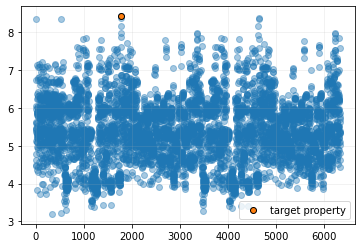

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score
import random 
from tqdm import tqdm
from celluloid import Camera # getting the camera

# active learning
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

target_IE = 5.59
y0 = (y.copy() - target_IE).abs() 

fig, ax = plt.subplots() 
ax.scatter(y.index, y.values,alpha=0.4)
ax.scatter(y.idxmax(), y.loc[y.idxmax()], ec='k',label='target property')
ax.grid(True, alpha=0.2) 
ax.legend(loc=4) 
plt.show() 

**Plot Index vs IE** and identify global maximum. In the above figure, we see that the global maximum IE is around 8.7 eV

### Define Acquisition  Functions

Here I define four different acquisition functions: the maximum uncertainty (MU), maximum expected improvement (MEI), maximum likelihood improvement (MLI), and the upper confidence bound (UCB). In addition, I use a mixed acquisition method which first employs a MU to reduce the overall uncertainty of the model, and then employs a MIE to optimize the material property.

**MU:**  
This function queries the sample with the highest uncertainty.
<br>
$$ x^* = arg\_max \enspace \sigma[f(x_i)]$$
<br>

<br>

**MEI:**  
This approach takes the maximum value of the prediction of the model over the possible experiments to run.

<br>

$$ x^* = arg\_max \enspace E[f(x_i)]$$

<br>

**MLI:**  
This approach tells us that we are expecting to query a region for which we see an improvement and sufficient uncertainty to have a high likelihood of getting a larger value.

$$ x^* = arg\_max \enspace \frac{E[f(x_i)] - E[f(x_{best})]}{\sigma[f(x_i)]}$$

$x_{best}$ is the current best value in the training dataset.


**UCB:**  
This strategy queries the sample with the maximum value of its mean prediction plus its uncertainty.
<br>
$$ x^* = arg\_max \enspace [E[f(x_i)] + \sigma[f(x_i)]]$$
<br>

$x^*$ is the new sample pulled using the acquistion function.  
$\sigma$ is the standard deviation ($\sigma^2$ is the variance)  
$f(x_i)$ is the model and $x_i$ is a given predicted data point.  
$E[...]$ is the expected value.

In [5]:
from sklearn.metrics import mean_absolute_error, r2_score
import random 
from tqdm import tqdm
from celluloid import Camera # getting the camera
from lolopy.learners import RandomForestRegressor

# acquisition functions
def update_random(y_pred, y_std, pool): 
    new_idx = y_pred.sample(n=1).index[0]
    pool.append(new_idx)
    return pool

def update_mu(y_pred, y_std, pool): 
    new_idx = y_std.idxmax() 
    pool.append(new_idx)
    return pool

def update_mei(y_pred, y_std, pool): 
    new_idx = y_pred.idxmax() 
    pool.append(new_idx)
    return pool

def update_mli(y_pred, y_std, pool): 
    ybest = y.loc[pool].max() 
    new_idx = ( (y_pred - ybest)/(y_std) ).idxmax()
    pool.append(new_idx)
    return pool

def update_ucb(y_pred, y_std, pool): 
    new_idx = (y_pred + y_std).idxmax()
    pool.append(new_idx)
    return pool

def train_activemodel(estimator, X, y, pool, method='GPR'): 
    xtrain, xtest = X[X.index.isin(pool)], X[~X.index.isin(pool)]
    ytrain, ytest = y[y.index.isin(pool)], y[~y.index.isin(pool)]
    
    if method == 'GPR': 
        estimator.fit(xtrain, ytrain)
        y_pred, y_std = estimator.predict(xtest, **{'return_std': True})
        y_pred = pd.Series(y_pred, index=ytest.index)
        y_std  = pd.Series(y_std, index=ytest.index)
        return y_pred, y_std
    elif method == 'RF':
        estimator = RandomForestRegressor() 
        estimator.fit(xtrain.to_numpy(), ytrain.to_numpy())
        y_pred, y_std = estimator.predict(xtest.to_numpy(), return_std=True)
        y_pred = pd.Series(y_pred, index=ytest.index)
        y_std  = pd.Series(y_std, index=ytest.index)
        return y_pred, y_std 

def id_current_max(pool):
    ytrain = y.loc[pool]
    y_best_idx = ytrain.idxmax()  
    y_best     = ytrain.max() 
    return y_best, y_best_idx



In [6]:

def active_learn_loop(X, y, n_iter, method):

    # identify global max 
    global_max_idx = y.idxmax() 
    global_max = y.max()

    # get inital pool of samples
    starting_pool = X.sample(n=10).index.tolist() 
    if global_max_idx in starting_pool: 
        starting_pool.remove(global_max_idx)
    
    # setup staring pools for each method
    idx_rand = starting_pool.copy() 
    idx_mu   = starting_pool.copy() 
    idx_mli   = starting_pool.copy() 
    idx_mei   = starting_pool.copy() 
    idx_ucb   = starting_pool.copy() 
    idx_mix   = starting_pool.copy() 
    
    METHOD = method
    res = [] 

    for i in tqdm(range(n_iter)): 
        # random selection
        y_best, y_best_idx = id_current_max(idx_rand)
        y_pred, y_std = train_activemodel(pipe, X, y, idx_rand, METHOD)
        idx_rand = update_random(y_pred, y_std, idx_rand)
        res.append([i, 'random', y_best, y_best_idx, len(idx_rand)])

        # MU selection
        y_best, y_best_idx = id_current_max(idx_mu)
        y_pred, y_std = train_activemodel(pipe, X, y, idx_mu, METHOD)
        idx_mu = update_mu(y_pred, y_std, idx_mu)
        res.append([i, 'mu', y_best, y_best_idx, len(idx_mu) ])

        # MEI selection
        y_best, y_best_idx = id_current_max(idx_mei)
        y_pred, y_std = train_activemodel(pipe, X ,y, idx_mei, METHOD)
        idx_mei = update_mei(y_pred, y_std, idx_mei)
        res.append([i, 'mei', y_best, y_best_idx, len(idx_mei) ])

        # MLI selection
        y_best, y_best_idx = id_current_max(idx_mli)
        y_pred, y_std = train_activemodel(pipe, X ,y, idx_mli, METHOD)
        idx_mli = update_mli(y_pred, y_std, idx_mli)
        res.append([i, 'mli', y_best, y_best_idx, len(idx_mli) ])

        # UCB selection
        y_best, y_best_idx = id_current_max(idx_ucb)
        y_pred, y_std = train_activemodel(pipe, X ,y, idx_ucb, METHOD)
        idx_ucb = update_ucb(y_pred, y_std, idx_ucb)
        res.append([i, 'ucb', y_best, y_best_idx, len(idx_ucb) ])

        # MIXED selection
        y_best, y_best_idx = id_current_max(idx_mix)
        y_pred, y_std = train_activemodel(pipe, X ,y, idx_mix, METHOD)
        if i <= 10: 
            idx_mix = update_mu(y_pred, y_std, idx_mix)
        if i > 10: 
            idx_mix = update_mei(y_pred, y_std, idx_mix)
        res.append([i, 'mixed', y_best, y_best_idx, len(idx_mix) ])

    columns = ['step', 'method', 'y_best', 'y_best_idx', 'n_data']
    res = pd.DataFrame(res,columns=columns)
    return res

In [7]:
# setup dataset 
X = features.reset_index(drop=True)
y = targets.reset_index(drop=True)

# identify global max 
global_max_idx = y.idxmax() 
global_max = y.max()

res_rf = active_learn_loop(X, y, n_iter=150, method='RF')

100%|██████████| 150/150 [05:39<00:00,  2.26s/it]


/home/daniel/opt/miniconda3/envs/ml-het/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'N data points')

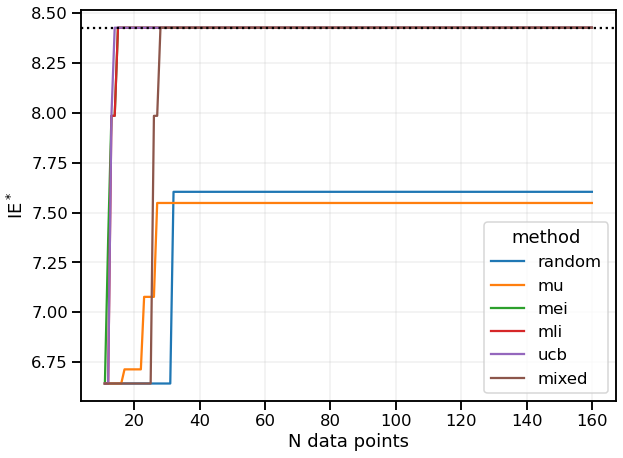

In [8]:
# plot 

res = res_rf.copy() 
sb.set_context('talk')
fs = np.array([6.4,4.8])
fig, ax = plt.subplots(figsize=fs*1.5)
sb.lineplot(res.n_data, res.y_best, hue=res.method, ax=ax)
ax.axhline(global_max, ls=':',c='k')
ax.grid(True, alpha=0.2)
ax.set_ylabel(r'IE$^*$')
ax.set_xlabel('N data points')

**RF Sequential Learning** In the above figure, we can see that a sequential learning approach can identify the global maximum IE in fewer steps compared to random selection. The MEI aquisition function showed the fastest convergence. While the random selection also quickly approaches the maxima, it does not find the global max. The MLI and UCB methods find the glboal max after ~15 iterations. 

In [9]:
# setup dataset 
X = features.reset_index(drop=True)
y = targets.reset_index(drop=True)

# identify global max 
global_max_idx = y.idxmax() 
global_max = y.max()

res_gpr = active_learn_loop(X, y, n_iter=150, method='GPR')

100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


/home/daniel/opt/miniconda3/envs/ml-het/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'N data points')

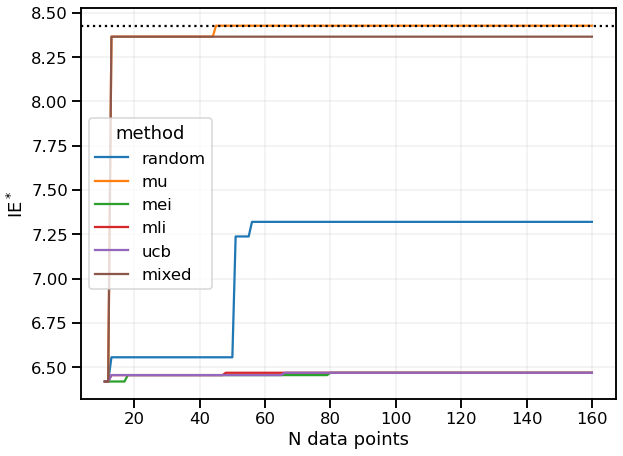

In [10]:
# plot 

res = res_gpr.copy() 
sb.set_context('talk')
fs = np.array([6.4,4.8])
fig, ax = plt.subplots(figsize=fs*1.5)
sb.lineplot(res.n_data, res.y_best, hue=res.method, ax=ax)
ax.axhline(global_max, ls=':',c='k')
ax.grid(True, alpha=0.2)
ax.set_ylabel(r'IE$^*$')
ax.set_xlabel('N data points')

**GPR Sequential Learning** In the above figure, we can again see the advantage of sequential learning. Using the GPR model, The MU and MIXED methods outperformed the random selection and other acquisition functions. This demonstrates that it is important to test different aquisition functions as there is no universal best. The MU and MIX methods might have been more succesful here because the GPR model was slower to learn compared to the RF model. 

### Optimize for a Specific IE

While identifing the greatest IE value in the dataset could be useful. It might be more useful to identify materials with a specific IE. To do this, I will map the features to a new response variable. The new response variable is essentially a metric of how close a predicted IE is to a target IE:

$y' = -|y - y^*|$

where $y'$ is the new target value we map to, $y$ is the DFT labeled IE, $y^*$ is the target IE. The negative sign means that the global max is now $y'>=$ than zero (i.e. still a maximization problem), and ensures that we can apply the same acquisition functions to the problem.

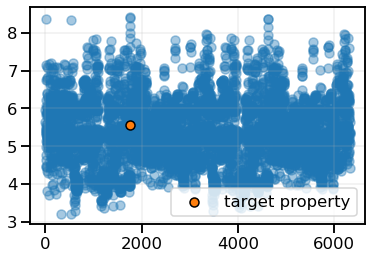

In [11]:
# setup dataset 
X = features.reset_index(drop=True)
y = targets.reset_index(drop=True)
y0 = y.copy() 

# adjust to target a specific IE 
target_IE = 5.56
y = abs(y.copy() - target_IE) * -1

fig, ax = plt.subplots() 
ax.scatter(y0.index, y0.values,alpha=0.4)
ax.scatter(y0.idxmax(), y0.loc[y.idxmax()], ec='k',label='target property')
ax.grid(True, alpha=0.2) 
ax.legend(loc=4) 
plt.show() 

**Plot Index vs IE** and identify global maximum. In the above figure, we can identify the target IE. 

In [12]:
# identify global max 
global_max_idx = y.idxmax() 
global_max = y.max() 

res_rf = active_learn_loop(X, y, n_iter=50, method='RF')

100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


/home/daniel/opt/miniconda3/envs/ml-het/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


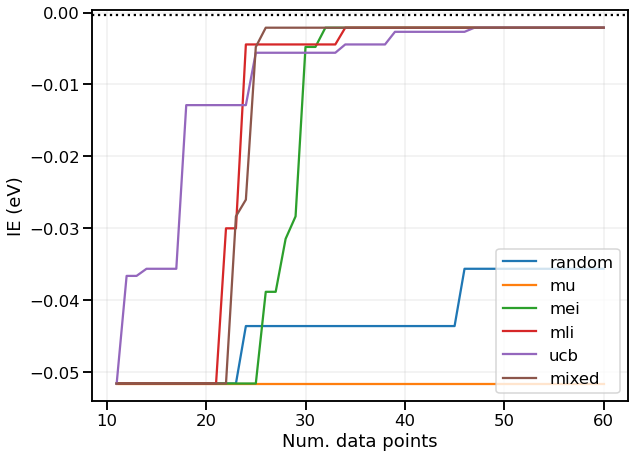

In [13]:
# plot results

res = res_rf.copy()

fs = np.array([6.4,4.8])
fig, ax = plt.subplots(figsize=fs*1.5)
sb.lineplot(res.n_data, res.y_best, hue=res.method, ax=ax)
ax.axhline(global_max, ls=':',c='k')
ax.legend(loc=4)
ax.set_xlabel('Num. data points')
ax.set_ylabel('IE (eV)')
ax.grid(True, alpha=0.2)

/home/daniel/opt/miniconda3/envs/ml-het/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


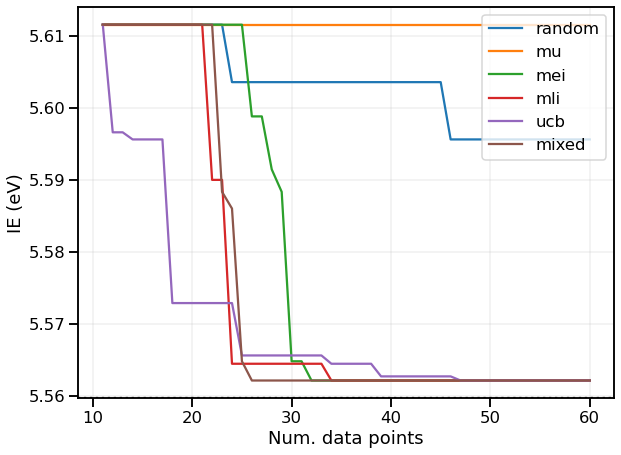

In [14]:
# plot results

res = res_rf.copy()

fs = np.array([6.4,4.8])
fig, ax = plt.subplots(figsize=fs*1.5)
sb.lineplot(res.n_data, y0.loc[res.y_best_idx].values, hue=res.method, ax=ax)
ax.axhline(y0.loc[global_max_idx], ls=':',c='k')
ax.legend(loc=1) 
ax.set_xlabel('Num. data points')
ax.set_ylabel('IE (eV)')
ax.grid(True, alpha=0.2)

**Sequential Learning**  In the above two figures we can see how sequential learning helps us converge on the target IE faster than random selection.